In [1]:
import os
import pandas as pd
import tensorflow as tf
import numpy as np
from tensorflow.keras.layers import TextVectorizatio
from sklearn.utils import shuffle
# import the required libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import unicodedata

In [2]:
from sklearn.utils import shuffle
df = pd.read_csv(r"C:\Users\Yashika\OneDrive\Desktop\Dissertation\data set\Final Dataset\Racial and ethical hate speech.csv")
df = df.sample(frac=1).reset_index(drop=True) #
df = df[['label','text']]
df = shuffle(df)  
#df['label'] =df['label'].map({ 'nothate':0, 'hate': 1})
df = df[['label','text']]
df.tail()

,label,text
10603,hate,I concur that due to the fact they are overedu...
25357,nothate,So here you have some fuckanometry lol: Firm a...
10567,hate,I do not like hating other races. I just want ...
25993,nothate,Britain used to be home to the most lovely thi...
6350,hate,What the frig are you talking about you camel ...


In [3]:
df['label'] =df['label'].map({ 'nothate':0, 'hate': 1})
df = df[['label','text']]
#df = shuffle(df)
df.tail()

,label,text
10603,1,I concur that due to the fact they are overedu...
25357,0,So here you have some fuckanometry lol: Firm a...
10567,1,I do not like hating other races. I just want ...
25993,0,Britain used to be home to the most lovely thi...
6350,1,What the frig are you talking about you camel ...


In [4]:
import pandas as pd
from sklearn.utils import resample

minority_class = df['label'].value_counts().idxmin()
print(minority_class)
# Separate majority and minority classes
majority_df = df[df['label'] != minority_class]
minority_df = df[df['label'] == minority_class]

# Downsample the majority class
majority_downsampled = resample(majority_df, replace=False, n_samples=len(minority_df), random_state=100)

# Combine the minority class DataFrame with the downsampled majority class DataFrame
balanced_df = pd.concat([majority_downsampled, minority_df])

# 'balanced_df' now contains a balanced dataset


1


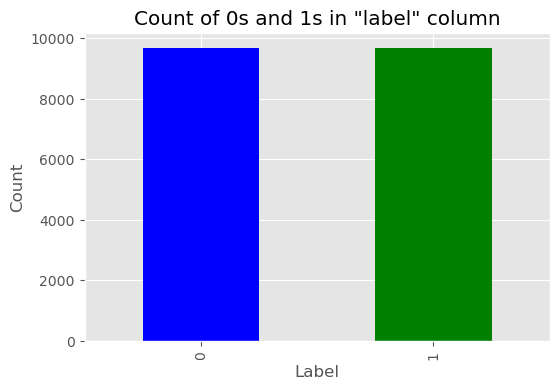

In [5]:
#print(balanced_df)
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'label' is the name of the column in your DataFrame
label_counts = balanced_df['label'].value_counts()

# Create a bar chart
plt.figure(figsize=(6, 4))  # Optional: Set the figure size
label_counts.plot(kind='bar', color=['blue', 'green'])  # Use color to distinguish 0s and 1s

# Add labels and title
plt.xlabel('Label')
plt.ylabel('Count')
plt.title('Count of 0s and 1s in "label" column')

plt.show()  # Display the plot

In [6]:
balanced_df = shuffle(balanced_df)
print(balanced_df.tail())

       label                                               text
26358      0  "U ain't white. Accept whatever injun or whate...
5667       1  The neckbeard loser with an Southeast/East Asi...
20144      0  There's a ton of people who dont exactly like ...
25808      1  The more i explore the world , the more i real...
3366       1  Where the fuck are the tv shows Billionaires o...


In [15]:
max_length = balanced_df['text'].str.len().max()

In [20]:
tokenizer = AutoTokenizer.from_pretrained("roberta-base") #Tokenizer

train_inputs = tokenizer(X_train.tolist(),padding='max_length', max_length= max_length, truncation=True, return_tensors='tf') 

train_labels = y_train

test_inputs = tokenizer(X_test.tolist(), padding='max_length', max_length=max_sequence_length, truncation=True, return_tensors='tf') #Tokenized text


test_labels = y_test

In [24]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import f1_score, confusion_matrix
from transformers import TFAutoModelForSequenceClassification
from tensorflow.keras.metrics import BinaryAccuracy  # Import BinaryAccuracy

In [25]:
class LossOnHistoryRobert(tf.keras.callbacks.Callback):
    def __init__(self, x_val, y_val):
        self.x_val = x_val
        self.y_val = y_val
        self.history = {
            'loss': [],
            'accuracy': [],
            'val_loss': [],
            'val_accuracy': [],
            'val_f1': [],
            'val_binary_accuracy': []  # Store binary accuracy
        }

    def on_epoch_end(self, epoch, logs={}):
        self.history['loss'].append(logs.get('loss'))
        self.history['accuracy'].append(logs.get('sparse_categorical_accuracy'))

        if logs.get('val_loss', -1) != -1:
            self.history['val_loss'].append(logs.get('val_loss'))

        if logs.get('val_sparse_categorical_accuracy', -1) != -1:
            self.history['val_accuracy'].append(logs.get('val_sparse_categorical_accuracy'))

        # Predict on validation data
        y_pred = self.model.predict(self.x_val)
        y_pred = np.argmax(y_pred.logits, axis=1)

        # Calculate F1 score
        f1 = f1_score(self.y_val, y_pred)

        # Calculate binary accuracy
        binary_accuracy = BinaryAccuracy()(self.y_val, tf.keras.backend.round(tf.convert_to_tensor(y_pred, dtype=tf.float32)))

        # Print confusion matrix
        print(confusion_matrix(self.y_val, y_pred))

        self.history['val_f1'].append(f1)
        self.history['val_binary_accuracy'].append(binary_accuracy.numpy())
        print('F1 Score:', f1)
        print('Binary Accuracy:', binary_accuracy.numpy())

# Assuming you have prepared your training and validation data as x_train, y_train, x_val, y_val

model = TFAutoModelForSequenceClassification.from_pretrained("roberta-base", num_labels=2)

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001, clipnorm=1.),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

# Create the custom callback
custom_callback = LossOnHistoryRobert(x_val, y_val)

# Train the model
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=32,
    epochs=10,
    verbose=1,
    callbacks=[custom_callback]
)


Epoch 1/10
849/849 [==============================] - 774s 905ms/step - loss: 0.6444 - binary_accuracy: 0.6147 - val_loss: 0.5634 - val_binary_accuracy: 0.7273
Epoch 2/10
849/849 [==============================] - 764s 900ms/step - loss: 0.5207 - binary_accuracy: 0.7493 - val_loss: 0.4450 - val_binary_accuracy: 0.7998
Epoch 3/10
849/849 [==============================] - 730s 860ms/step - loss: 0.4524 - binary_accuracy: 0.7949 - val_loss: 0.3906 - val_binary_accuracy: 0.8321
Epoch 4/10
849/849 [==============================] - 719s 847ms/step - loss: 0.4012 - binary_accuracy: 0.8211 - val_loss: 0.3718 - val_binary_accuracy: 0.8450
Epoch 5/10
849/849 [==============================] - 744s 876ms/step - loss: 0.3640 - binary_accuracy: 0.8355 - val_loss: 0.3176 - val_binary_accuracy: 0.8551
Epoch 6/10
849/849 [==============================] - 756s 890ms/step - loss: 0.3262 - binary_accuracy: 0.8534 - val_loss: 0.2775 - val_binary_accuracy: 0.8781
Epoch 7/10
849/849 [====================

In [28]:

# Predict using the trained model
y_pred = model.predict(dict(test_inputs))



1/1 [==============================] - 0s 179ms/step
              precision    recall  f1-score   support

           0       0.95      0.89      0.92      1002
           1       0.89      0.95      0.92       934

    accuracy                           0.92      1936
   macro avg       0.92      0.92      0.92      1936
weighted avg       0.92      0.92      0.92      1936



In [29]:
from sklearn.metrics import confusion_matrix

# Assuming you have actual labels (y_test) and predicted labels (y_pred)
conf_matrix = confusion_matrix(true_labels, predicted_labels)

print("Confusion Matrix:")
print(conf_matrix)


Confusion Matrix:
[[892 110]
 [ 50 884]]


<Figure size 800x500 with 0 Axes>

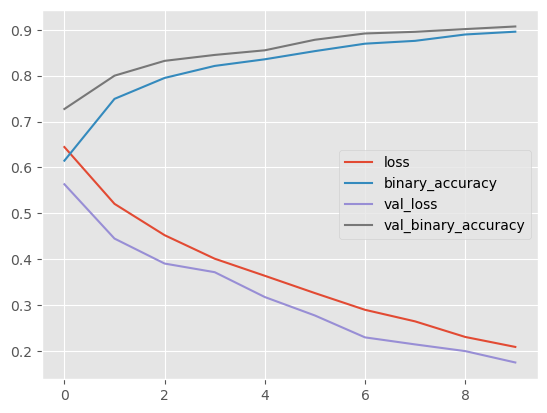

In [36]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.show()